In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import seaborn as sns
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

In [3]:
# GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [4]:
import os, sys
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [5]:
import zipfile
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/dataset/UTKFace.zip", 'r')
# zip_ref = zipfile.ZipFile("UTKFace3.zip", 'r')
zip_ref.extractall("/content/")
zip_ref.close()

In [6]:
# labels - age, gender, ethnicity
data_dir = './UTKFace'
images = []
age_labels = []
gender_labels = []
race_labels = []

for filename in os.listdir(data_dir):
    if filename.endswith('.jpg'):
        # Split the filename
        parts = filename.split('_')
        if len(parts) != 4:
            # Skip files that don't have all four expected parts
            continue
        age, gender, race, _ = parts
        try:
            age = float(age)
            gender = int(gender)
            race = int(race)
        except ValueError:
            # Skip files with non-numeric labels
            continue
        # Add image path and corresponding labels to lists
        image_path = os.path.join(data_dir, filename)
        images.append(image_path)
        age_labels.append(age)
        gender_labels.append(gender)
        race_labels.append(race)
                
# Verify the updated data
print("Total images:", len(images))
print("Total age labels:", len(age_labels))
print("Total gender labels:", len(gender_labels))
print("Total race labels:", len(race_labels))

Total images: 23165
Total age labels: 23165
Total gender labels: 23165
Total race labels: 23165


In [7]:
# convert to dataframe

import pandas as pd
df = pd.DataFrame()
# df['image'], df['age'], df['gender'] = images, age_labels, gender_labels
df['image'], df['age'] = images, age_labels
df.head()

,image,age
0,./UTKFace/72_0_1_20170111210712990.jpg.chip.jpg,72.0
1,./UTKFace/22_1_2_20170116172137259.jpg.chip.jpg,22.0
2,./UTKFace/65_1_0_20170110151430189.jpg.chip.jpg,65.0
3,./UTKFace/54_0_1_20170117190137490.jpg.chip.jpg,54.0
4,./UTKFace/52_0_1_20170111200619762.jpg.chip.jpg,52.0


In [8]:
df

,image,age
0,./UTKFace/72_0_1_20170111210712990.jpg.chip.jpg,72.0
1,./UTKFace/22_1_2_20170116172137259.jpg.chip.jpg,22.0
2,./UTKFace/65_1_0_20170110151430189.jpg.chip.jpg,65.0
3,./UTKFace/54_0_1_20170117190137490.jpg.chip.jpg,54.0
4,./UTKFace/52_0_1_20170111200619762.jpg.chip.jpg,52.0
...,...,...
23160,./UTKFace/67_1_0_20170110152820302.jpg.chip.jpg,67.0
23161,./UTKFace/27_0_0_20170117144505322.jpg.chip.jpg,27.0
23162,./UTKFace/62_1_2_20170116191832323.jpg.chip.jpg,62.0
23163,./UTKFace/25_0_0_20170117151647102.jpg.chip.jpg,25.0


<Figure size 700x600 with 0 Axes>

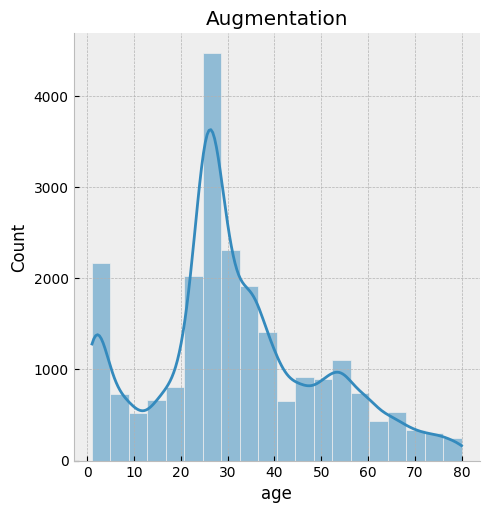

In [10]:
# Set the size of the figure
plt.style.use('bmh')
plt.figure(figsize=(7, 6))  # Set the size to 8 inches wide and 6 inches tall

# df = df[df['age'] < 80]
sns.displot(df['age'],kde=True, bins=20)
plt.title('Augmentation')
# Show the plot

plt.show()

In [12]:
df, test_df = train_test_split(df, test_size=0.2, stratify=df['age'])
# df = df.reset_index(drop=True)
print(len(test_df))
print(len(df))

3350
13400


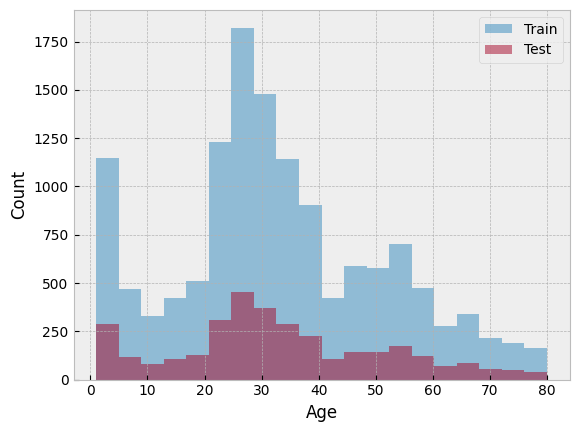

In [13]:
import matplotlib.pyplot as plt

# Plot histogram of age for train and test data
plt.hist(df['age'], bins=20, alpha=0.5, label='Train')
plt.hist(test_df['age'], bins=20, alpha=0.5, label='Test')
plt.xlabel('Age')
plt.ylabel('Count')
plt.legend()
plt.show()


In [ ]:
condition = (df['age'] > 31) | (df['age'] < 21)

# use boolean indexing to filter the rows and duplicate them twice
duplicated_rows = df[condition].copy()
duplicated_twice = pd.concat([duplicated_rows, duplicated_rows])

# concatenate the original dataframe and the duplicated rows twice
df = pd.concat([df, duplicated_twice], ignore_index=True)

df.head()

,image,age
0,./UTKFace/70_0_0_20170117175502596.jpg.chip.jpg,70.0
1,./UTKFace/40_1_1_20170112214918832.jpg.chip.jpg,40.0
2,./UTKFace/53_0_3_20170104220848558.jpg.chip.jpg,53.0
3,./UTKFace/40_1_0_20170117134334933.jpg.chip.jpg,40.0
4,./UTKFace/76_1_3_20170110181654947.jpg.chip.jpg,76.0


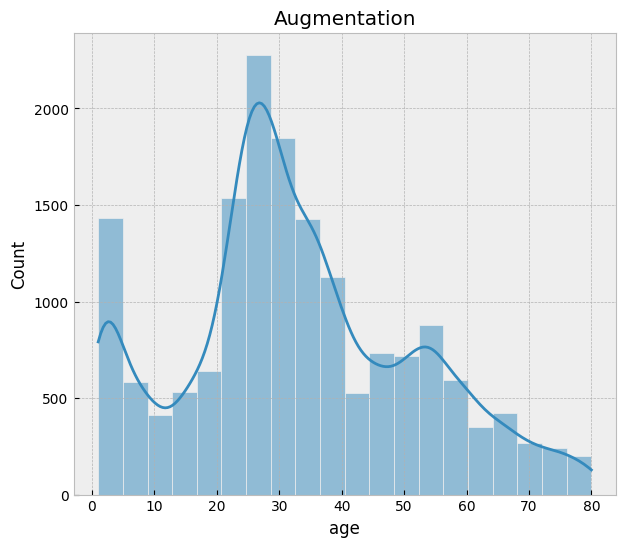

16750
21383


In [11]:

# Count the number of images per age
image_counts = df['age'].value_counts()

cut_off = 600

# Remove images with counts exceeding 280
for age, count in image_counts.items():
    if count > cut_off:
        excess_images = df[df['age'] == age].sample(count - cut_off)
        df = df.drop(excess_images.index)
df = df.reset_index(drop=True)

# Set the size of the figure
plt.style.use('bmh')
plt.figure(figsize=(7, 6))  # Set the size to 8 inches wide and 6 inches tall

# Create the histogram with KDE using seaborn
sns.histplot(df['age'], kde=True, bins=20)
plt.title('Augmentation')
# Show the plot

plt.show()
print(len(df))
print(len(df) + len(test_df))

In [14]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split
import random
from PIL import ImageEnhance
import torchvision.transforms.functional as TF


# class CustomDataset(Dataset):
#     def __init__(self, dataframe, transform=None):
#         self.dataframe = dataframe
#         self.transform = transform

#     def __len__(self):
#         return len(self.dataframe)

#     def __getitem__(self, index):
#         image_path, age = self.dataframe.iloc[index]
#         image = Image.open(image_path)
#         image = self.transform(image)

#         return image, age

class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        # self.age_labels = [0, 1, 2, 3]
        # self.age_intervals = [(1, 19), (20, 39), (40, 59), (60, 80)]
        self.age_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
        self.age_intervals = [(1, 8), (9, 16), (17, 24), (25, 32), (33, 40), (41, 48), (49, 56), (57, 64), (65, 72), (73, 80)]
        self.age_group_labels = []

        for age in self.dataframe['age']:
            for idx, interval in enumerate(self.age_intervals):
                if interval[0] <= age <= interval[1]:
                    self.age_group_labels.append(idx)
                    break

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        image_path, age = self.dataframe.iloc[index]
        image = Image.open(image_path)
        image = self.transform(image)

        age_group = self.age_group_labels[index]
        age_group = torch.tensor(age_group)

        return image, age_group



train_df, valid_df = train_test_split(df, test_size=0.1, stratify=df['age'])
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)


# Define transformations for train, validation, and test sets
transform_train = transforms.Compose([
#      transforms.RandomCrop(180),
    transforms.Resize((224, 224), antialias=True),  # Resize the image with antialiasing
    # transforms.Grayscale(),  # Convert the image to grayscale
    transforms.RandomRotation(10),
#     transforms.Lambda(lambda x: ImageEnhance.Contrast(x).enhance(0.5)),  # Increase contrast
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
])


transform_test = transforms.Compose([
    # transforms.Grayscale(), 
    transforms.Resize((224, 224), antialias=True),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
])

# Create the datasets
train_dataset = CustomDataset(train_df, transform=transform_train)
valid_dataset = CustomDataset(valid_df, transform=transform_train)
test_dataset = CustomDataset(test_df, transform=transform_test)

# Create data loaders
batch_size = 64

# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# valid_loader = DataLoader(valid_dataset, batch_size=batch_size)
# test_loader = DataLoader(test_dataset, batch_size=batch_size)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
val_loader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=8)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


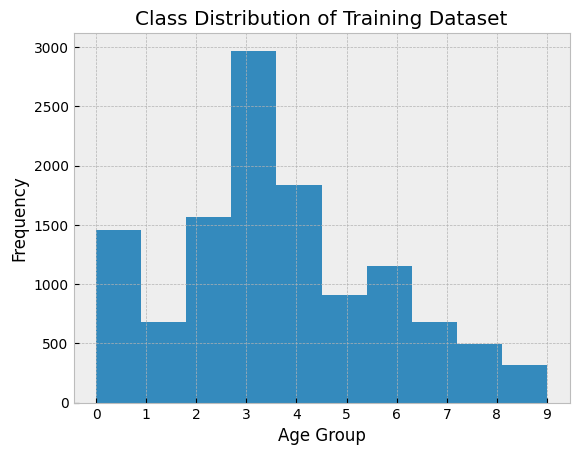

In [15]:
import matplotlib.pyplot as plt

age_groups = train_dataset.age_group_labels
n_bins = len(train_dataset.age_labels)

plt.hist(age_groups, bins=n_bins)
plt.xticks(range(n_bins), train_dataset.age_labels)
plt.xlabel('Age Group')
plt.ylabel('Frequency')
plt.title('Class Distribution of Training Dataset')
plt.show()


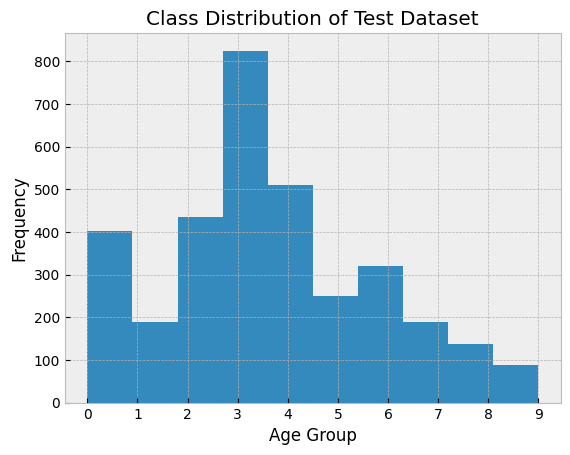

In [16]:
import matplotlib.pyplot as plt

age_groups = test_dataset.age_group_labels
n_bins = len(test_dataset.age_labels)

plt.hist(age_groups, bins=n_bins)
plt.xticks(range(n_bins), test_dataset.age_labels)
plt.xlabel('Age Group')
plt.ylabel('Frequency')
plt.title('Class Distribution of Test Dataset')
plt.show()


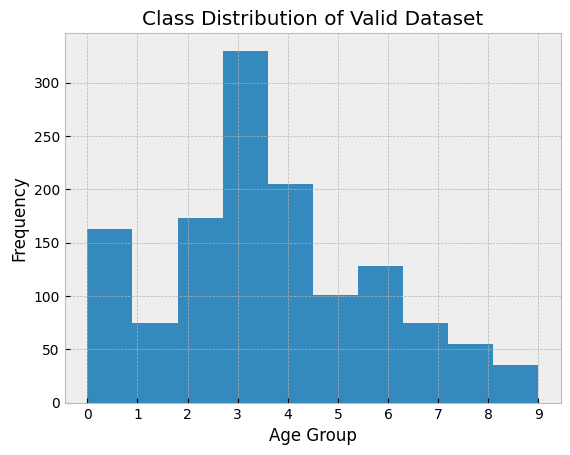

In [17]:
import matplotlib.pyplot as plt

age_groups = valid_dataset.age_group_labels
n_bins = len(valid_dataset.age_labels)

plt.hist(age_groups, bins=n_bins)
plt.xticks(range(n_bins), valid_dataset.age_labels)
plt.xlabel('Age Group')
plt.ylabel('Frequency')
plt.title('Class Distribution of Valid Dataset')
plt.show()


In [ ]:
# Check the number of channels in the train loader
sample_batch = next(iter(train_loader))
sample_images, _ = sample_batch  # Assuming the images are in the first element of each batch

# Check the shape of the sample image
print(sample_images.shape)  # The shape will be in the format: (batch_size, channels, height, width)

num_channels = sample_images.shape[1]
print(f"Number of channels: {num_channels}")


sample_batch = next(iter(train_loader))
sample_images, _ = sample_batch

# Check the minimum and maximum pixel values in the sample images
min_value = sample_images.min().item()
max_value = sample_images.max().item()

print(f"Minimum pixel value: {min_value}")
print(f"Maximum pixel value: {max_value}")
print(len(train_loader)*batch_size)


torch.Size([32, 1, 128, 128])
Number of channels: 1
Minimum pixel value: 0.0
Maximum pixel value: 1.0
40416


## vgg16

In [18]:
model = models.vgg16(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 255MB/s]


In [19]:
# 모델의 마지막 층을 새로운 Fully Connected layer로 대체합니다.
n_features = model.classifier[-1].in_features
model.classifier[-1] = nn.Linear(n_features, 10)
model = model.to(device)

In [ ]:
# Load the pre-trained VGG16 model
model = models.vgg16(pretrained=True)

# Freeze all the layers except the last one
for param in model.parameters():
    param.requires_grad = True
model.classifier[-1] = nn.Linear(4096, 4)
model = model.to(device)

In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# # 수정된 레이어와 새로운 레이어를 함께 fine-tuning합니다.
# learning_rate = 0.001
# optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
# criterion = nn.CrossEntropyLoss()


history_dense = {'accuracy': [], 'val_accuracy': []}

for epoch in range(10):
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data

        inputs = inputs.to(device)
        labels = labels.to(device)

        # inputs = inputs.permute(0, 3, 1, 2)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        outputs = outputs.to(device)

        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        if (i + 1) % 100 == 0 or (i + 1) == len(val_loader):
            acc = 100 * correct / total
            correct_val = 0
            total_val = 0
            val_loss = 0
            with torch.no_grad():
                for data in val_loader:
                    inputs, labels = data
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    outputs = model(inputs.float())
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()

                    _, predicted = torch.max(outputs.data, 1)
                    total_val += labels.size(0)
                    correct_val += (predicted == labels).sum().item()
            val_acc = 100 * correct_val / total_val
            val_loss /= len(val_loader)

            print('[%d, %5d/%d] loss: %.3f accuracy: %.3f val_loss: %.3f val_accuracy: %.3f' %
                  (epoch + 1, i + 1, len(train_loader), running_loss / 100, acc, val_loss, val_acc))
            running_loss = 0.0
            correct = 0
            total = 0

    # save train and validation accuracy for current epoch
    history_dense['accuracy'].append(acc)
    history_dense['val_accuracy'].append(val_acc)

[1,    21/189] loss: 0.495 accuracy: 21.131 val_loss: 2.171 val_accuracy: 24.627
[1,   100/189] loss: 1.697 accuracy: 22.330 val_loss: 2.147 val_accuracy: 21.194
[2,    21/189] loss: 0.439 accuracy: 26.042 val_loss: 2.066 val_accuracy: 28.358
[2,   100/189] loss: 1.633 accuracy: 27.215 val_loss: 2.009 val_accuracy: 29.925
[3,    21/189] loss: 0.414 accuracy: 29.539 val_loss: 1.945 val_accuracy: 30.299
[3,   100/189] loss: 1.472 accuracy: 31.388 val_loss: 1.799 val_accuracy: 32.687
[4,    21/189] loss: 0.354 accuracy: 36.830 val_loss: 1.680 val_accuracy: 35.522
[4,   100/189] loss: 1.334 accuracy: 35.819 val_loss: 1.632 val_accuracy: 37.090
[5,    21/189] loss: 0.349 accuracy: 35.714 val_loss: 1.595 val_accuracy: 38.955
[5,   100/189] loss: 1.277 accuracy: 37.638 val_loss: 1.627 val_accuracy: 37.164
[6,    21/189] loss: 0.329 accuracy: 40.327 val_loss: 1.574 val_accuracy: 37.388
[6,   100/189] loss: 1.219 accuracy: 39.280 val_loss: 1.536 val_accuracy: 38.060
[7,    21/189] loss: 0.320 a

In [21]:
model.eval()  
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_acc = 100 * correct / total
print('Test Accuracy: %.3f %%' % (test_acc))

Test Accuracy: 43.015 %
